# 基于GloVe和torchtext的sentiment analysis

In [1]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np
import matplotlib.pyplot as plt

In [18]:
#加载本地词向量
glove_1 = torchtext.vocab.GloVe(name="6B", dim=300, cache='D:/course/text mining/corpus/glove.6B/', max_vectors=20000)

In [2]:
# The first time you run this will download a ~823MB file
#中文Glove资源，https://github.com/candlewill/Chinsese_word_vectors
glove = torchtext.vocab.GloVe(name="6B", dim=50, max_vectors=20000)

.vector_cache\glove.6B.zip: 862MB [05:12, 2.76MB/s]                                                                    
100%|████████████████████████████████████████████████████████████████████████▉| 19999/20000 [00:00<00:00, 26878.80it/s]


In [3]:
import csv

def get_data():
    return csv.reader(open("D:/course/text mining/10-情感分析/data/training.1600000.processed.noemoticon.csv", "rt", encoding="latin-1"))

for i, line in enumerate(get_data()):
    if i > 10:
        break
    print(line)

['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY', '_TheSpecialOne_', "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"]
['0', '1467810672', 'Mon Apr 06 22:19:49 PDT 2009', 'NO_QUERY', 'scotthamilton', "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"]
['0', '1467810917', 'Mon Apr 06 22:19:53 PDT 2009', 'NO_QUERY', 'mattycus', '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds']
['0', '1467811184', 'Mon Apr 06 22:19:57 PDT 2009', 'NO_QUERY', 'ElleCTF', 'my whole body feels itchy and like its on fire ']
['0', '1467811193', 'Mon Apr 06 22:19:57 PDT 2009', 'NO_QUERY', 'Karoli', "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. "]
['0', '1467811372', 'Mon Apr 06 22:20:00 PDT 2009', 'NO_QUERY', 'joy_wolf', '@Kwesidei not the whole crew ']
['0', '14

In [5]:
def split_tweet(tweet):
    # separate punctuations
    tweet = tweet.replace(".", " . ") \
                 .replace(",", " , ") \
                 .replace(";", " ; ") \
                 .replace("?", " ? ")
    return tweet.split()

for i, line in enumerate(get_data()):
    if i > 10:
        break
    print(sum(int(w in glove.stoi) for w in split_tweet(line[-1])))

12
20
14
9
20
4
2
18
3
3
8


In [7]:
def get_tweet_vectors(glove_vector):
    train, valid, test = [], [], []
    for i, line in enumerate(get_data()):
        tweet = line[-1]
        if i % 59 == 0:
            vector_sum = sum(glove_vector[w] for w in split_tweet(tweet))
            label = torch.tensor(int(line[0] == "4")).long()
            if i % 5 < 3:
                train.append((vector_sum, label))
            elif i % 5 == 4:
                valid.append((vector_sum, label))
            else:
                test.append((vector_sum, label))
    return train, valid, test

In [8]:
train, valid, test = get_tweet_vectors(glove)

train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)

In [9]:
def train_network(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for tweets, labels in train_loader:
            optimizer.zero_grad()
            pred = model(tweets)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))     
        if epoch % 5 == 4:
            epochs.append(epoch)
            train_acc.append(get_accuracy(model, train_loader))
            valid_acc.append(get_accuracy(model, valid_loader))
            print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
                epoch+1, loss, train_acc[-1], valid_acc[-1]))

    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for tweets, labels in data_loader:
        output = model(tweets)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

Epoch 5; Loss 0.558503; Train Acc 0.648393; Val Acc 0.642883
Epoch 10; Loss 0.671621; Train Acc 0.657796; Val Acc 0.663348
Epoch 15; Loss 0.710187; Train Acc 0.660316; Val Acc 0.661136
Epoch 20; Loss 0.610064; Train Acc 0.665110; Val Acc 0.663164
Epoch 25; Loss 0.658962; Train Acc 0.665847; Val Acc 0.665929
Epoch 30; Loss 0.573685; Train Acc 0.669658; Val Acc 0.666298
Epoch 35; Loss 0.853223; Train Acc 0.672546; Val Acc 0.667588
Epoch 40; Loss 0.567913; Train Acc 0.673714; Val Acc 0.667220
Epoch 45; Loss 0.460003; Train Acc 0.675926; Val Acc 0.667588
Epoch 50; Loss 0.552091; Train Acc 0.676971; Val Acc 0.668879
Epoch 55; Loss 0.688886; Train Acc 0.678692; Val Acc 0.664639
Epoch 60; Loss 0.405596; Train Acc 0.681581; Val Acc 0.664823
Epoch 65; Loss 0.581914; Train Acc 0.681335; Val Acc 0.665192
Epoch 70; Loss 0.513636; Train Acc 0.682564; Val Acc 0.670907
Epoch 75; Loss 0.503758; Train Acc 0.684900; Val Acc 0.668510
Epoch 80; Loss 0.724651; Train Acc 0.687604; Val Acc 0.664823
Epoch 85;

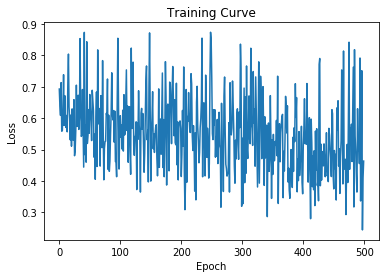

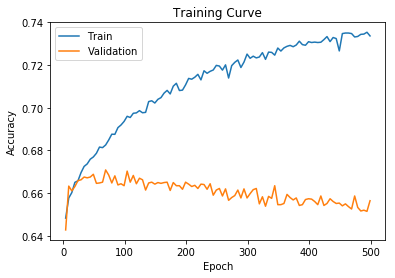

0.6613200589970502

In [10]:
mymodel = nn.Sequential(nn.Linear(50, 40),
                        nn.ReLU(),
                        nn.Linear(40, 20),
                        nn.ReLU(),
                        nn.Linear(20, 2))
train_network(mymodel, train_loader, valid_loader, num_epochs=500, learning_rate=1e-4)
get_accuracy(mymodel, test_loader)

Epoch 5; Loss 0.585680; Train Acc 0.561736; Val Acc 0.568768
Epoch 10; Loss 0.756198; Train Acc 0.604019; Val Acc 0.616519
Epoch 15; Loss 0.844210; Train Acc 0.627743; Val Acc 0.635324
Epoch 20; Loss 0.707838; Train Acc 0.644521; Val Acc 0.647677
Epoch 25; Loss 0.614624; Train Acc 0.651281; Val Acc 0.654499
Epoch 30; Loss 0.687329; Train Acc 0.654416; Val Acc 0.659476
Epoch 35; Loss 0.483743; Train Acc 0.655952; Val Acc 0.662426
Epoch 40; Loss 0.571194; Train Acc 0.656075; Val Acc 0.662979
Epoch 45; Loss 0.697118; Train Acc 0.659763; Val Acc 0.662979
Epoch 50; Loss 0.549162; Train Acc 0.660685; Val Acc 0.661689


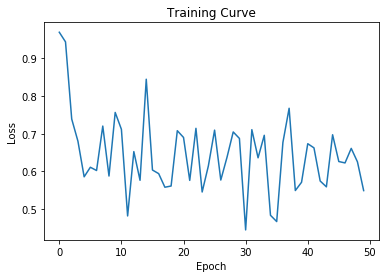

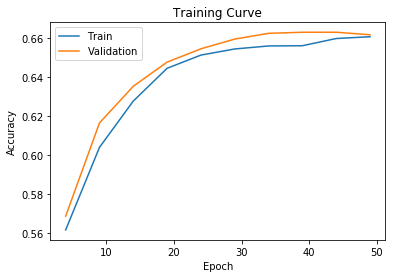

0.6592920353982301

In [11]:
mymodel = nn.Linear(50, 2)
train_network(mymodel, train_loader, valid_loader, num_epochs=50, learning_rate=1e-4)
get_accuracy(mymodel, test_loader)

100%|████████████████████████████████████████████████████████████████████████▉| 19999/20000 [00:01<00:00, 19981.61it/s]


Epoch 5; Loss 0.659930; Train Acc 0.654662; Val Acc 0.647861
Epoch 10; Loss 0.716127; Train Acc 0.671379; Val Acc 0.669432
Epoch 15; Loss 0.449085; Train Acc 0.677402; Val Acc 0.670354
Epoch 20; Loss 0.512968; Train Acc 0.683056; Val Acc 0.676991
Epoch 25; Loss 0.552101; Train Acc 0.688034; Val Acc 0.676622
Epoch 30; Loss 0.955829; Train Acc 0.690492; Val Acc 0.674594
Epoch 35; Loss 0.540164; Train Acc 0.693012; Val Acc 0.679572
Epoch 40; Loss 0.830397; Train Acc 0.697253; Val Acc 0.686025
Epoch 45; Loss 0.767682; Train Acc 0.693995; Val Acc 0.673488
Epoch 50; Loss 0.460694; Train Acc 0.701493; Val Acc 0.679388
Epoch 55; Loss 0.431690; Train Acc 0.701862; Val Acc 0.681969
Epoch 60; Loss 0.722200; Train Acc 0.703522; Val Acc 0.684366
Epoch 65; Loss 0.620033; Train Acc 0.710036; Val Acc 0.684181
Epoch 70; Loss 0.570496; Train Acc 0.712126; Val Acc 0.686394
Epoch 75; Loss 0.638934; Train Acc 0.712187; Val Acc 0.686947
Epoch 80; Loss 0.651584; Train Acc 0.715568; Val Acc 0.685656
Epoch 85;

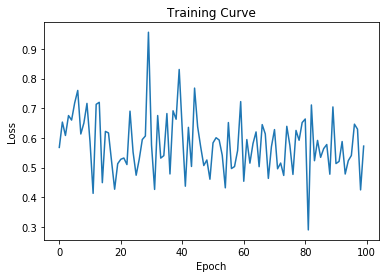

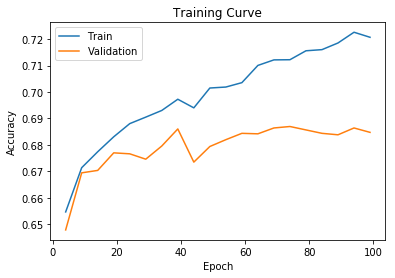

0.683075221238938

In [12]:
glove = torchtext.vocab.GloVe(name="6B", dim=100, max_vectors=20000)
train, valid, test = get_tweet_vectors(glove)
train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)

mymodel = nn.Sequential(nn.Linear(100, 45), nn.ReLU(), nn.Linear(45, 2))
train_network(mymodel, train_loader, valid_loader, num_epochs=100, learning_rate=1e-4)
get_accuracy(mymodel, test_loader)

#### 课后作业：
waimai_10k.csv